In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector

from polapy.competitiveness import blais_lago, grofman_selb
from polapy.polarization import within_ep, between_ep, esteban_ray

ModuleNotFoundError: No module named 'polapy'

In [ ]:
!pip install polapy --user

  Created wheel for polapy: filename=polapy-0.0.2-py3-none-any.whl size=2370 sha256=a90027b302ac5088f167b7a843d18b3f3d8d2541f0c07e4e951239c962e5c781
  Stored in directory: c:\users\cnava\appdata\local\pip\cache\wheels\2b\dd\5e\7535fcf737c6d5ce8d1e4491b06c6fe59c08cbfbf33709f4d3
Successfully built polapy


In this notebook, we propose an algoritmic implementation for calculating the antagonism of candidate $i$ by using different definitions of polarization.

In [2]:
class ElectionAgent(Agent):
    """ An agent in an election model."""
    def __init__(self, unique_id, model, candidates, p):
        super().__init__(unique_id, model)
        self.choice = np.random.choice(candidates, 1, p=p)

    def step(self):
        pass

class ElectionModel(Model):
    def __init__(self, N=1000, candidates=["A"], p=[1], width=10, height=10) -> None:
        self.num_agents = N
        self.n_candidates = len(candidates)
        self.candidates = candidates
        self.schedule = RandomActivation(self)
        self.grid = MultiGrid(width, height, True)

        for i in range(self.num_agents):
            a = ElectionAgent(i, self, candidates=candidates, p=p)
            self.schedule.add(a)
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

        self.datacollector = DataCollector(          
            agent_reporters={"State": "state"})
        
    def step(self):
        """Advance the model by one step."""

        # The model's step will go here for now this will call the step method of each agent and print the agent's unique_id
        self.schedule.step()

In [8]:
model = ElectionModel(N=10000, candidates=["A", "B", "C"], p=[0.1, 0.2, 0.7])
model.step()

df = pd.DataFrame([x.choice for x in model.schedule.agents], columns=["candidate"])
df["votes"] = 1
df.head()

,candidate,votes
0,C,1
1,C,1
2,B,1
3,C,1
4,C,1


In [9]:
data = df.groupby("candidate").agg({"votes": "sum"}).reset_index()
data["share"] = data["votes"] / data["votes"].sum()

data

,candidate,votes,share
0,A,1046,0.1046
1,B,2031,0.2031
2,C,6923,0.6923


In [ ]:
blais_lago(data, candidate="candidate", votes="votes", n_seats=5, system="smp")

NameError: name 'blais_lago' is not defined

In [ ]:
candidates = list("abcdefghijklmnopqrstuvw")[0:2]

output = []
polling_id = 1
for loop in range(3):
    for candidate_a in candidates:
        for candidate_b in candidates:
            rate = 0 if candidate_a != candidate_b else 1
            rate = 1/len(candidates)
            output.append({
                "candidate": candidate_b,
                "rate": rate,
                "polling_id": polling_id
            })
        polling_id += 1

df = pd.DataFrame(output)
df["value"] = df["rate"] * 100
df

,candidate,rate,polling_id,value
0,a,0.5,1,50.0
1,b,0.5,1,50.0
2,a,0.5,2,50.0
3,b,0.5,2,50.0
4,a,0.5,3,50.0
5,b,0.5,3,50.0
6,a,0.5,4,50.0
7,b,0.5,4,50.0
8,a,0.5,5,50.0
9,b,0.5,5,50.0


In [ ]:
blais_lago(df, candidate="candidate", votes="value", system="smp")

(0.0,
    candidate  rate  polling_id  value  seats
 0          a   0.5           1    0.0    0.0
 1          b   0.5           1    0.0    0.0
 2          a   0.5           2    0.0    0.0
 3          b   0.5           2    0.0    0.0
 4          a   0.5           3    0.0    0.0
 5          b   0.5           3    0.0    0.0
 6          a   0.5           4    0.0    0.0
 7          b   0.5           4    0.0    0.0
 8          a   0.5           5    0.0    0.0
 9          b   0.5           5    0.0    0.0
 10         a   0.5           6    0.0    0.0
 11         b   0.5           6    0.0    0.0)

In [ ]:
test = df.groupby(["election_id", "candidate"]).agg({"value": "sum"})
test["rate"] = test.groupby(level=[0], group_keys=False).apply(lambda x: x/x.sum())
test = test.reset_index()

test.groupby("election_id").apply(reynal_querol).sort_values()

KeyError: 'election_id'

In [ ]:
df.groupby("candidate").apply(lambda x: esteban_ray(x))

candidate
a    0.0
b    0.0
dtype: float64

In [ ]:
df.groupby("candidate").apply(lambda x: tsui_wang(x))

candidate
a    1.0
b    1.0
dtype: float64

In [ ]:
df.groupby("candidate").apply(dispersion)

candidate
a    0.5
b    0.5
dtype: float64

In [ ]:
df.groupby("candidate").apply(reynal_querol)

candidate
a    1.0
b    1.0
dtype: float64

In [ ]:
df.groupby("candidate").apply(lambda x: weighted_dispersion(x, df["value"].sum()))

candidate
a    0.0
b    0.0
dtype: float64

## Generates synthetic data
For each combination of $\mu$ and $\sigma$, we generated 100 elections

In [ ]:
import random

output = []
epi = {}
idx = 1
for iteration in range(5):
    for mu in [0.5, 0.66, 0.75, 0.8333, 1]:
        for sigma in [0.0025, 0.05, 0.10, 0.25]:
        
            distribution = [random.gauss(mu=mu, sigma=sigma) for x in range(100)]

            df_a = pd.DataFrame(distribution, columns=["rate"])
            df_a["candidate"] = "A"
            df_a["polling_id"] = range(df_a.shape[0])
            df_a.loc[df_a["rate"] <= 0, "rate"] = 0
            df_a.loc[df_a["rate"] >= 1, "rate"] = 1

            df_a["rate3"] = df_a["rate"].copy()
            df_a["rate2"] = df_a["rate"].apply(lambda x: np.round(x, 2))
            df_a["rate"] = df_a["rate"].apply(lambda x: x - x%0.01)

            df_b = df_a.copy()
            df_b["candidate"] = "B"
            df_b["rate"] = 1 - df_b["rate"]

            df = pd.concat([df_a, df_b], ignore_index=True)
            df["election_id"] = idx + 1
            idx += 1
            df["votes"] = df["rate"] * 100
            df["mu"] = mu
            df["sigma"] = sigma
            output.append(df)
            bw, ant = between_ep(df, unit="polling_id")
            wt, ant = within_ep(df, unit="polling_id")
            epi[idx + 1] = {
                "within": wt,
                "between": bw,
                "total": bw + wt
            }

df = pd.concat(output, ignore_index=True)
df.head()

,rate,candidate,polling_id,rate3,rate2,election_id,votes,mu,sigma
0,0.50,A,0,0.500182,0.5,2,50.0,0.5,0.0025
1,0.49,A,1,0.497048,0.5,2,49.0,0.5,0.0025
2,0.49,A,2,0.499858,0.5,2,49.0,0.5,0.0025
3,0.49,A,3,0.497153,0.5,2,49.0,0.5,0.0025
4,0.49,A,4,0.497793,0.5,2,49.0,0.5,0.0025


In [ ]:
def i(x): 
    output_df = x.groupby(["candidate"]).agg({"votes": "sum"}).reset_index()
    v, output_df = blais_lago(output_df, candidate="candidate", votes="votes", system="smp")
    return v

blais_lago_v = pd.merge(
    df.groupby(["election_id"]).apply(lambda x: i(x)).reset_index().rename(columns={0: "value"}),
    df[["election_id", "mu", "sigma"]].drop_duplicates(), 
    on="election_id"
)

blais_lago_v.sort_values("value")


,election_id,value,mu,sigma
42,44,0.0002,0.5,0.1000
22,24,0.0026,0.5,0.1000
62,64,0.0046,0.5,0.1000
61,63,0.0056,0.5,0.0500
0,2,0.0084,0.5,0.0025
...,...,...,...,...
56,58,0.9800,1.0,0.0025
76,78,0.9800,1.0,0.0025
36,38,0.9800,1.0,0.0025
96,98,0.9800,1.0,0.0025


In [ ]:
blais_lago(df.query("election_id == 44").groupby("candidate").sum(), candidate="candidate", votes="votes", system="smp")

(0.0002,
             rate  polling_id     rate3  rate2  election_id   votes    mu  \
 candidate                                                                  
 A          50.01        4950  50.55058  50.57         4400  5001.0  50.0   
 B          49.99        4950  50.55058  50.57         4400  4999.0  50.0   
 
            sigma  seats   value  
 candidate                        
 A           10.0    0.0  0.0000  
 B           10.0    2.0  0.0002  )

In [ ]:
df.query("election_id == 44").groupby("candidate").sum()

,rate,polling_id,rate3,rate2,election_id,votes,mu,sigma
candidate,,,,,,,,
A,50.01,4950,50.55058,50.57,4400,5001.0,50.0,10.0
B,49.99,4950,50.55058,50.57,4400,4999.0,50.0,10.0


In [ ]:
df_ER = df.groupby(["election_id", "candidate"]).apply(lambda x: esteban_ray(x, alpha=0.25, pi="votes", y="rate")).groupby(level=[0]).sum()\
    .reset_index().rename(columns={0: "value"})

df_ER = pd.merge(df_ER, df[["election_id", "mu", "sigma"]].drop_duplicates(), on="election_id")
df_ER.head()

,election_id,value,mu,sigma
0,2,0.003081,0.50,0.0025
1,3,0.036388,0.50,0.0500
2,4,0.063608,0.50,0.1000
3,5,0.157581,0.50,0.2500
4,6,0.003156,0.66,0.0025


In [ ]:
df_RQ = df.groupby(["election_id", "candidate"]).apply(lambda x: reynal_querol(x)).groupby(level=[0]).sum()\
    .reset_index().rename(columns={0: "value"})
df_RQ = pd.merge(df_RQ, df[["election_id", "mu", "sigma"]].drop_duplicates(), on="election_id")
df_RQ.head()

,election_id,value,mu,sigma
0,2,1.9832,0.50,0.0025
1,3,0.9212,0.50,0.0500
2,4,-1.2248,0.50,0.1000
3,5,-21.7492,0.50,0.2500
4,6,-7.5952,0.66,0.0025


In [ ]:
test = df.groupby(["election_id", "candidate"]).agg({"votes": "sum"})
test["rate"] = test.groupby(level=[0], group_keys=False).apply(lambda x: x/x.sum())
test = test.reset_index()
df_RQ = test.groupby("election_id").apply(reynal_querol).reset_index().rename(columns={0: "value"})
df_RQ = pd.merge(df_RQ, df[["election_id", "mu", "sigma"]].drop_duplicates(), on="election_id")
df_RQ.head()

,election_id,value,mu,sigma
0,2,0.999929,0.50,0.0025
1,3,0.999919,0.50,0.0500
2,4,0.999846,0.50,0.1000
3,5,0.999452,0.50,0.2500
4,6,0.904148,0.66,0.0025


In [ ]:
df_ER2 = df.groupby(["election_id", "candidate"]).apply(lambda x: esteban_ray(x, alpha=1, pi="votes", y="rate")).groupby(level=[0]).sum()\
    .reset_index().rename(columns={0: "value"})
df_ER2 = pd.merge(df_ER2, df[["election_id", "mu", "sigma"]].drop_duplicates(), on="election_id")
df_ER2.head()

,election_id,value,mu,sigma
0,2,0.000097,0.50,0.0025
1,3,0.001162,0.50,0.0500
2,4,0.002060,0.50,0.1000
3,5,0.005868,0.50,0.2500
4,6,0.000100,0.66,0.0025


In [ ]:
df_DP = df.groupby(["election_id", "candidate"]).apply(lambda x: dispersion(x)).groupby(level=[0]).sum()\
    .reset_index().rename(columns={0: "value"})
df_DP = pd.merge(df_DP, df[["election_id", "mu", "sigma"]].drop_duplicates(), on="election_id")

df_DP.head()

,election_id,value,mu,sigma
0,2,0.009871,0.50,0.0025
1,3,0.103475,0.50,0.0500
2,4,0.179149,0.50,0.1000
3,5,0.486769,0.50,0.2500
4,6,0.009992,0.66,0.0025


In [ ]:
df_BW = df.groupby(["election_id"]).apply(lambda x: between_ep(x, score="rate", unit="polling_id")[0]).groupby(level=[0]).sum()\
    .reset_index().rename(columns={0: "value"})
df_BW = pd.merge(df_BW, df[["election_id", "mu", "sigma"]].drop_duplicates(), on="election_id")

df_BW.head()

,election_id,value,mu,sigma
0,2,0.991601,0.50,0.0025
1,3,0.919813,0.50,0.0500
2,4,0.852445,0.50,0.1000
3,5,0.589189,0.50,0.2500
4,6,0.690434,0.66,0.0025


In [ ]:
df_WT = df.groupby(["election_id"]).apply(lambda x: within_ep(x, score="rate", unit="polling_id")[0]).groupby(level=[0]).sum()\
    .reset_index().rename(columns={0: "value"})
df_WT = pd.merge(df_WT, df[["election_id", "mu", "sigma"]].drop_duplicates(), on="election_id")

df_WT.head()

,election_id,value,mu,sigma
0,2,0.009744,0.50,0.0025
1,3,0.080374,0.50,0.0500
2,4,0.147578,0.50,0.1000
3,5,0.410236,0.50,0.2500
4,6,0.009983,0.66,0.0025


In [ ]:
# df_TW = df.groupby(["election_id", "candidate"]).apply(lambda x: tsui_wang(x, gamma=0.5)).groupby(level=[0]).sum()\
#     .reset_index().rename(columns={0: "value"})

# df_TW = pd.merge(df_TW, df[["election_id", "mu", "sigma"]].drop_duplicates(), on="election_id")
# df_TW.head()

In [ ]:
# df_TW2 = df.groupby(["election_id", "candidate"]).apply(lambda x: tsui_wang(x, gamma=0.75)).groupby(level=[0]).sum()\
#     .reset_index().rename(columns={0: "value"})

# df_TW2 = pd.merge(df_TW2, df[["election_id", "mu", "sigma"]].drop_duplicates(), on="election_id")
# df_TW2.head()

In [ ]:
# df_EP = pd.merge(df_BW, df_WT, on=["election_id", "mu", "sigma"])
# df_EP["value"] = df_EP["votes_x"] + df_EP["votes_y"]
# df_EP.head()

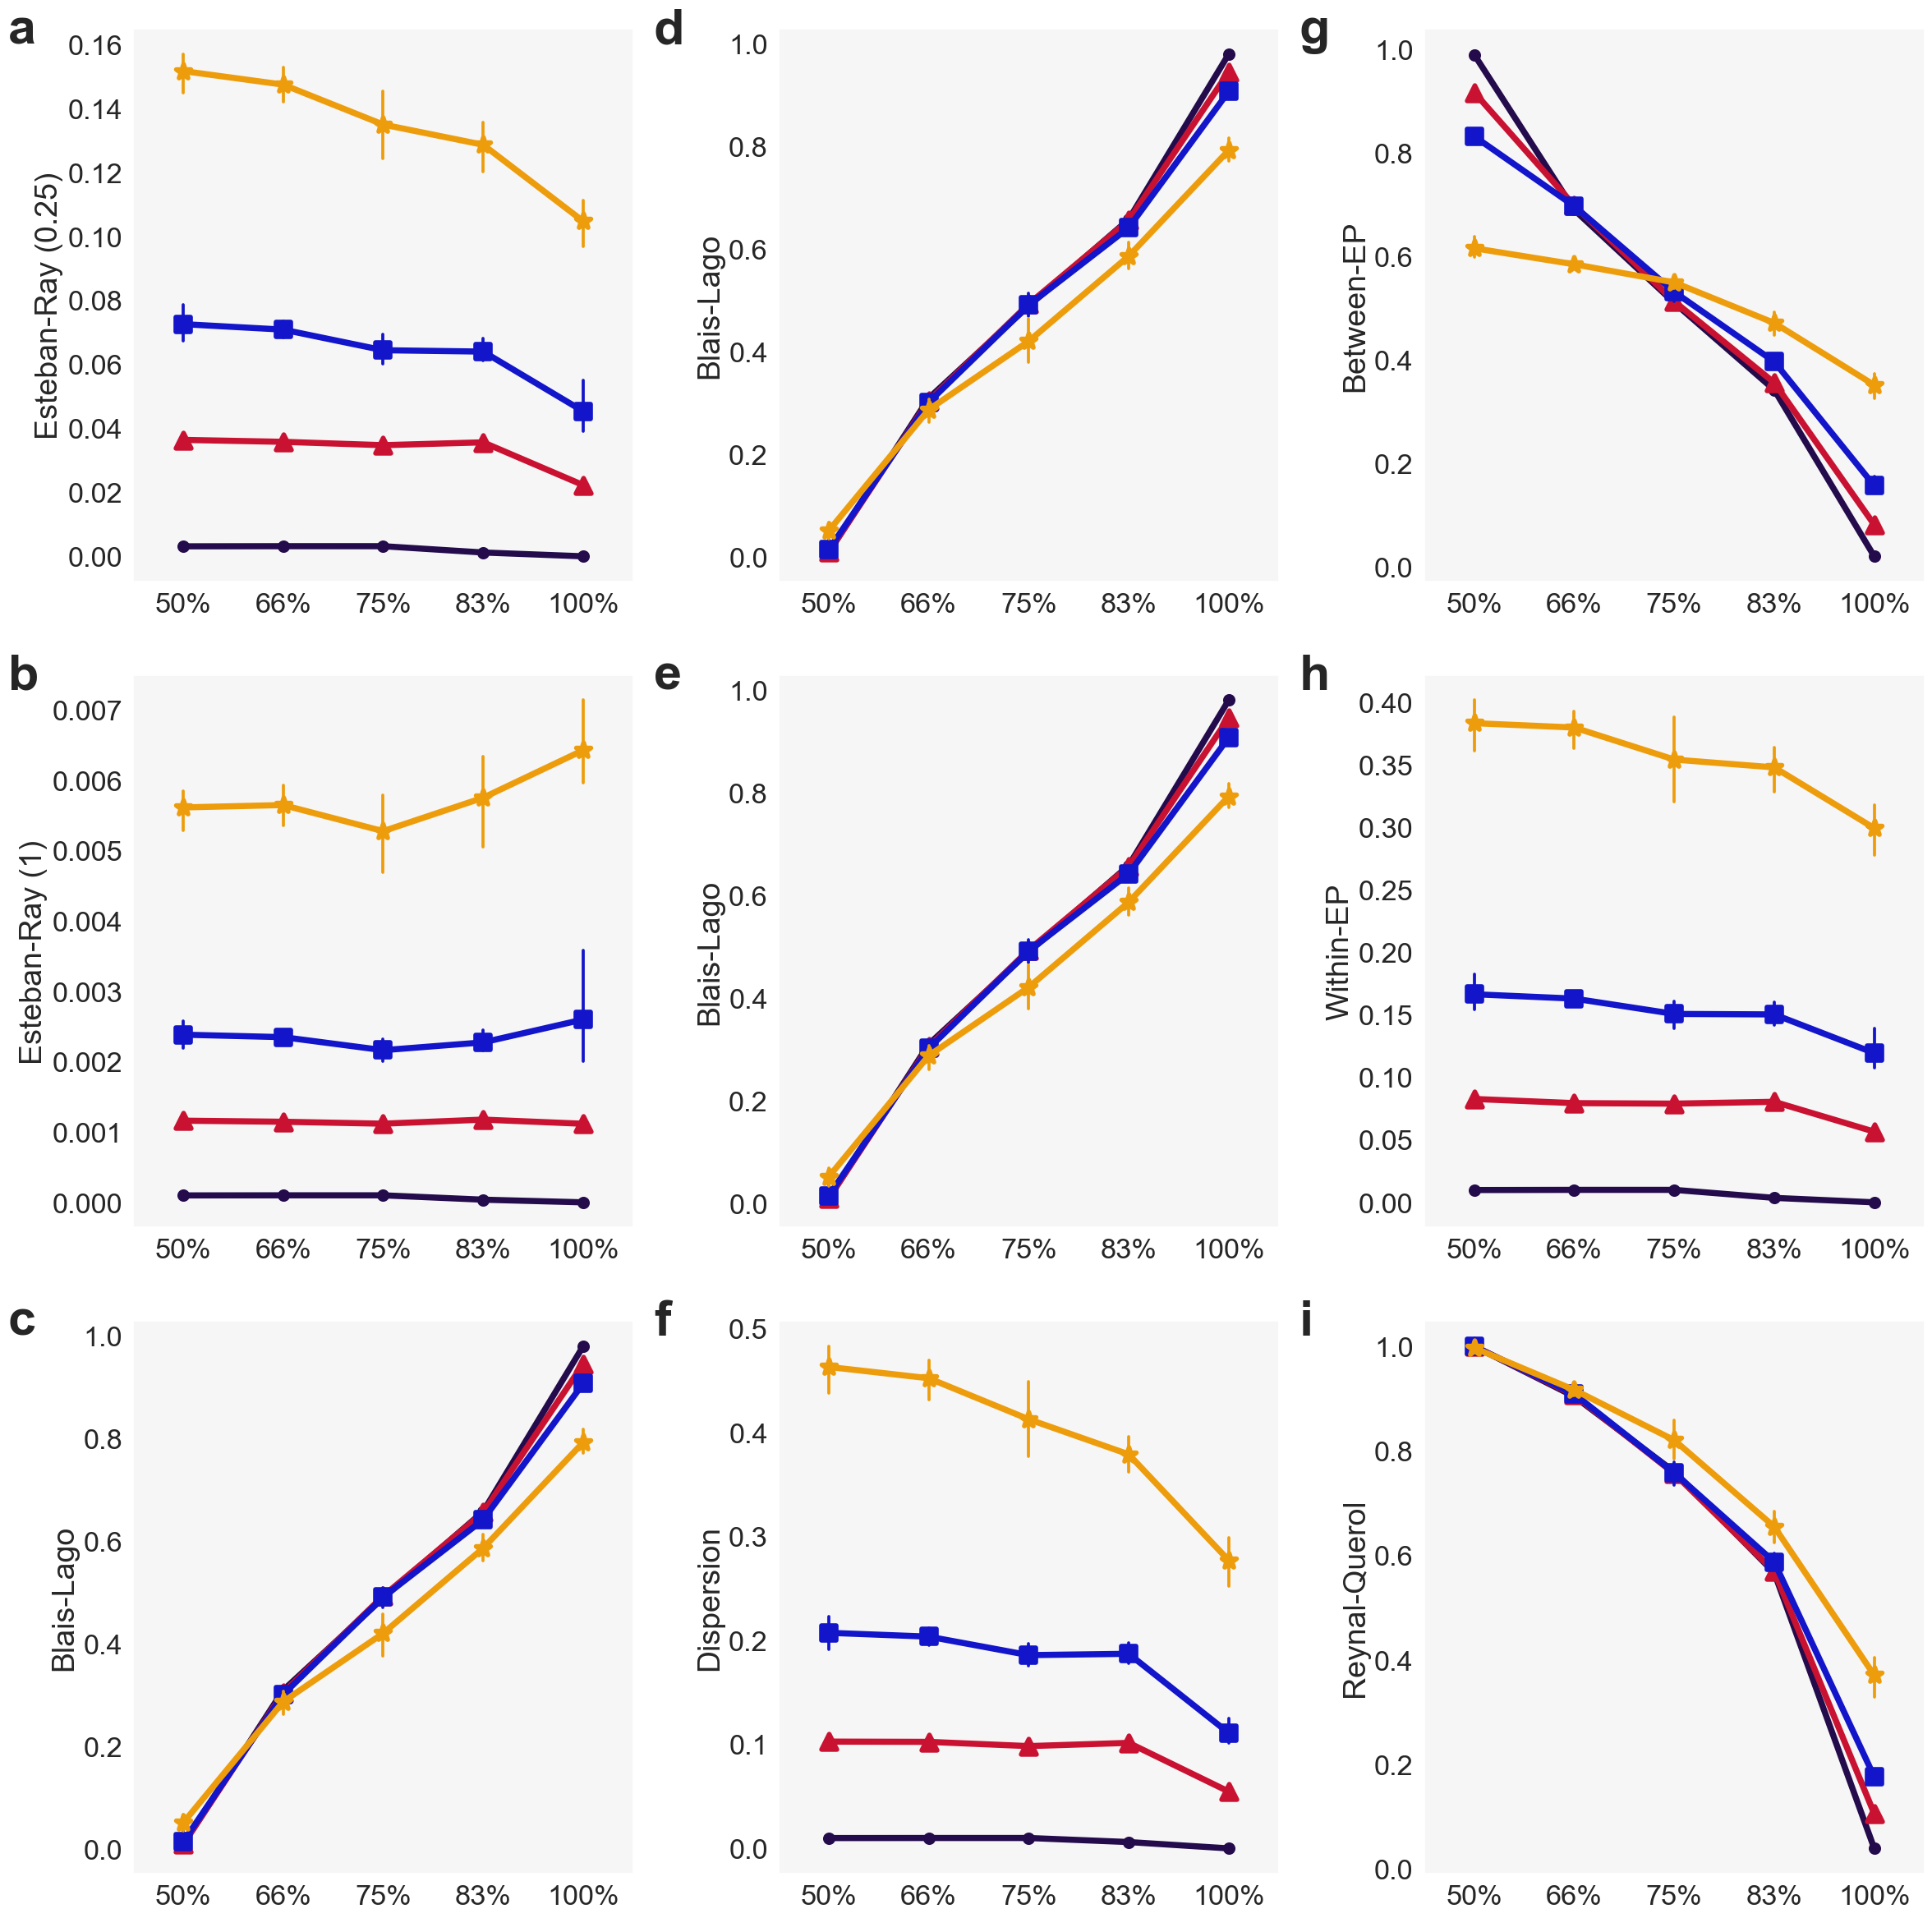

In [ ]:
sns.set(font_scale=2.25, rc={"axes.facecolor": "#f6f6f6", "axes.grid" : False})

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(24, 24))
labels = list("abcdefghijklm")

i = 0
for idx, item in enumerate([
    ("Esteban-Ray (0.25)", df_ER),
    ("Esteban-Ray (1)", df_ER2),
    # ("Wang-Tsui (0.5)", df_TW),
    # ("Wang-Tsui (0.75)", df_TW2),
    ("Blais-Lago", blais_lago_v),
    ("Blais-Lago", blais_lago_v),
    ("Blais-Lago", blais_lago_v),
    ("Dispersion", df_DP),
    ("Between-EP", df_BW),
    ("Within-EP", df_WT),
    # ("EP", df_EP),
    ("Reynal-Querol", df_RQ)
]):
    label, df_item = item
    df_item = df_item.copy()
    df_item["mu"] = df_item["mu"].apply(lambda x: f"{int(x * 100)}%")
    ax = axs[idx%3, int(idx/3)]#
    sns.pointplot(
        x="mu", hue="sigma", 
        scale=2, y="value", 
        markers=[".", "^", "s", "*"], 
        palette=["#230B4C", "#C91232", "#1215C9", "#ED9D0C"], 
        data=df_item, ax=ax)
    # ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
    ax.set_ylabel(label)
    ax.set_xlabel("")
    ax.text(-0.25, 0.975, labels[i], fontsize=44, transform=ax.transAxes, fontweight=700)
    i += 1

    leg = ax.legend()
    leg.remove()

# sns.despine(offset=10, trim=True)
fig.savefig(f"Figures_Appendix/Comparison_Polarization_Simulations.pdf")

fig.tight_layout()


In [ ]:
from scipy.stats import pearsonr

polarization = [
    ("Esteban-Ray (0.25)", df_ER),
    ("Esteban-Ray (1)", df_ER2),
    # ("Wang-Tsui (0.5)", df_TW),
    # ("Wang-Tsui (0.75)", df_TW2),
    ("Blais-Lago", blais_lago_v),
    ("Dispersion", df_DP),
    ("Between-EP", df_BW),
    ("Within-EP", df_WT),
    # ("EP", df_EP),
    ("Reynal-Querol", df_RQ)
]

output = []
df_output = []
for mu in df_ER.mu.unique():
    for sigma in df_ER.sigma.unique():
        for xx in polarization:
            x1 = xx[1]
            x1 = x1[(x1["mu"] == mu) & (x1["sigma"] == sigma)]
            for yy in polarization:
                y1 = yy[1]
                y1 = y1[(y1["mu"] == mu) & (y1["sigma"] == sigma)]

                if xx[0] != yy[0]:
                    try:
                        value, pvalue = pearsonr(x1["value"], y1["value"])
                        output.append({
                            "value": value,
                            "pvalue": pvalue,
                            "xx": xx[0],
                            "yy": yy[0],
                            "mu": mu,
                            "sigma": sigma
                        })
                    except:
                        pass

        tmp = pd.DataFrame(output)
        # tmp["mu"] = mu
        df_output.append(tmp)

data = pd.concat(df_output).drop_duplicates()
data

C:\Users\cnava\AppData\Roaming\Python\Python310\site-packages\scipy\stats\_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


,value,pvalue,xx,yy,mu,sigma
0,1.000000,6.582110e-11,Esteban-Ray (0.25),Esteban-Ray (1),0.5,0.0025
1,-0.448758,4.484269e-01,Esteban-Ray (0.25),Blais-Lago,0.5,0.0025
2,0.999993,2.315976e-08,Esteban-Ray (0.25),Dispersion,0.5,0.0025
3,0.448768,4.484155e-01,Esteban-Ray (0.25),Between-EP,0.5,0.0025
4,1.000000,3.042667e-10,Esteban-Ray (0.25),Within-EP,0.5,0.0025
...,...,...,...,...,...,...
835,0.214561,7.289228e-01,Reynal-Querol,Esteban-Ray (1),1.0,0.2500
836,-0.999885,1.480713e-06,Reynal-Querol,Blais-Lago,1.0,0.2500
837,0.986318,1.917092e-03,Reynal-Querol,Dispersion,1.0,0.2500
838,0.893533,4.102937e-02,Reynal-Querol,Between-EP,1.0,0.2500


In [ ]:
data[(data["xx"] == "Within-EP") & ~(data["yy"].isin(["Between-EP", "Within-EP"]))]

,value,pvalue,xx,yy,mu,sigma
30,1.000000,3.042667e-10,Within-EP,Esteban-Ray (0.25),0.5,0.0025
31,0.999999,1.246983e-09,Within-EP,Esteban-Ray (1),0.5,0.0025
32,-0.449558,4.475173e-01,Within-EP,Blais-Lago,0.5,0.0025
33,0.999996,1.038004e-08,Within-EP,Dispersion,0.5,0.0025
35,0.495851,3.955837e-01,Within-EP,Reynal-Querol,0.5,0.0025
...,...,...,...,...,...,...
828,0.903521,3.544851e-02,Within-EP,Esteban-Ray (0.25),1.0,0.2500
829,0.393339,5.124166e-01,Within-EP,Esteban-Ray (1),1.0,0.2500
830,-0.934463,1.994117e-02,Within-EP,Blais-Lago,1.0,0.2500
831,0.980617,3.230034e-03,Within-EP,Dispersion,1.0,0.2500


Text(0, 0.5, '')

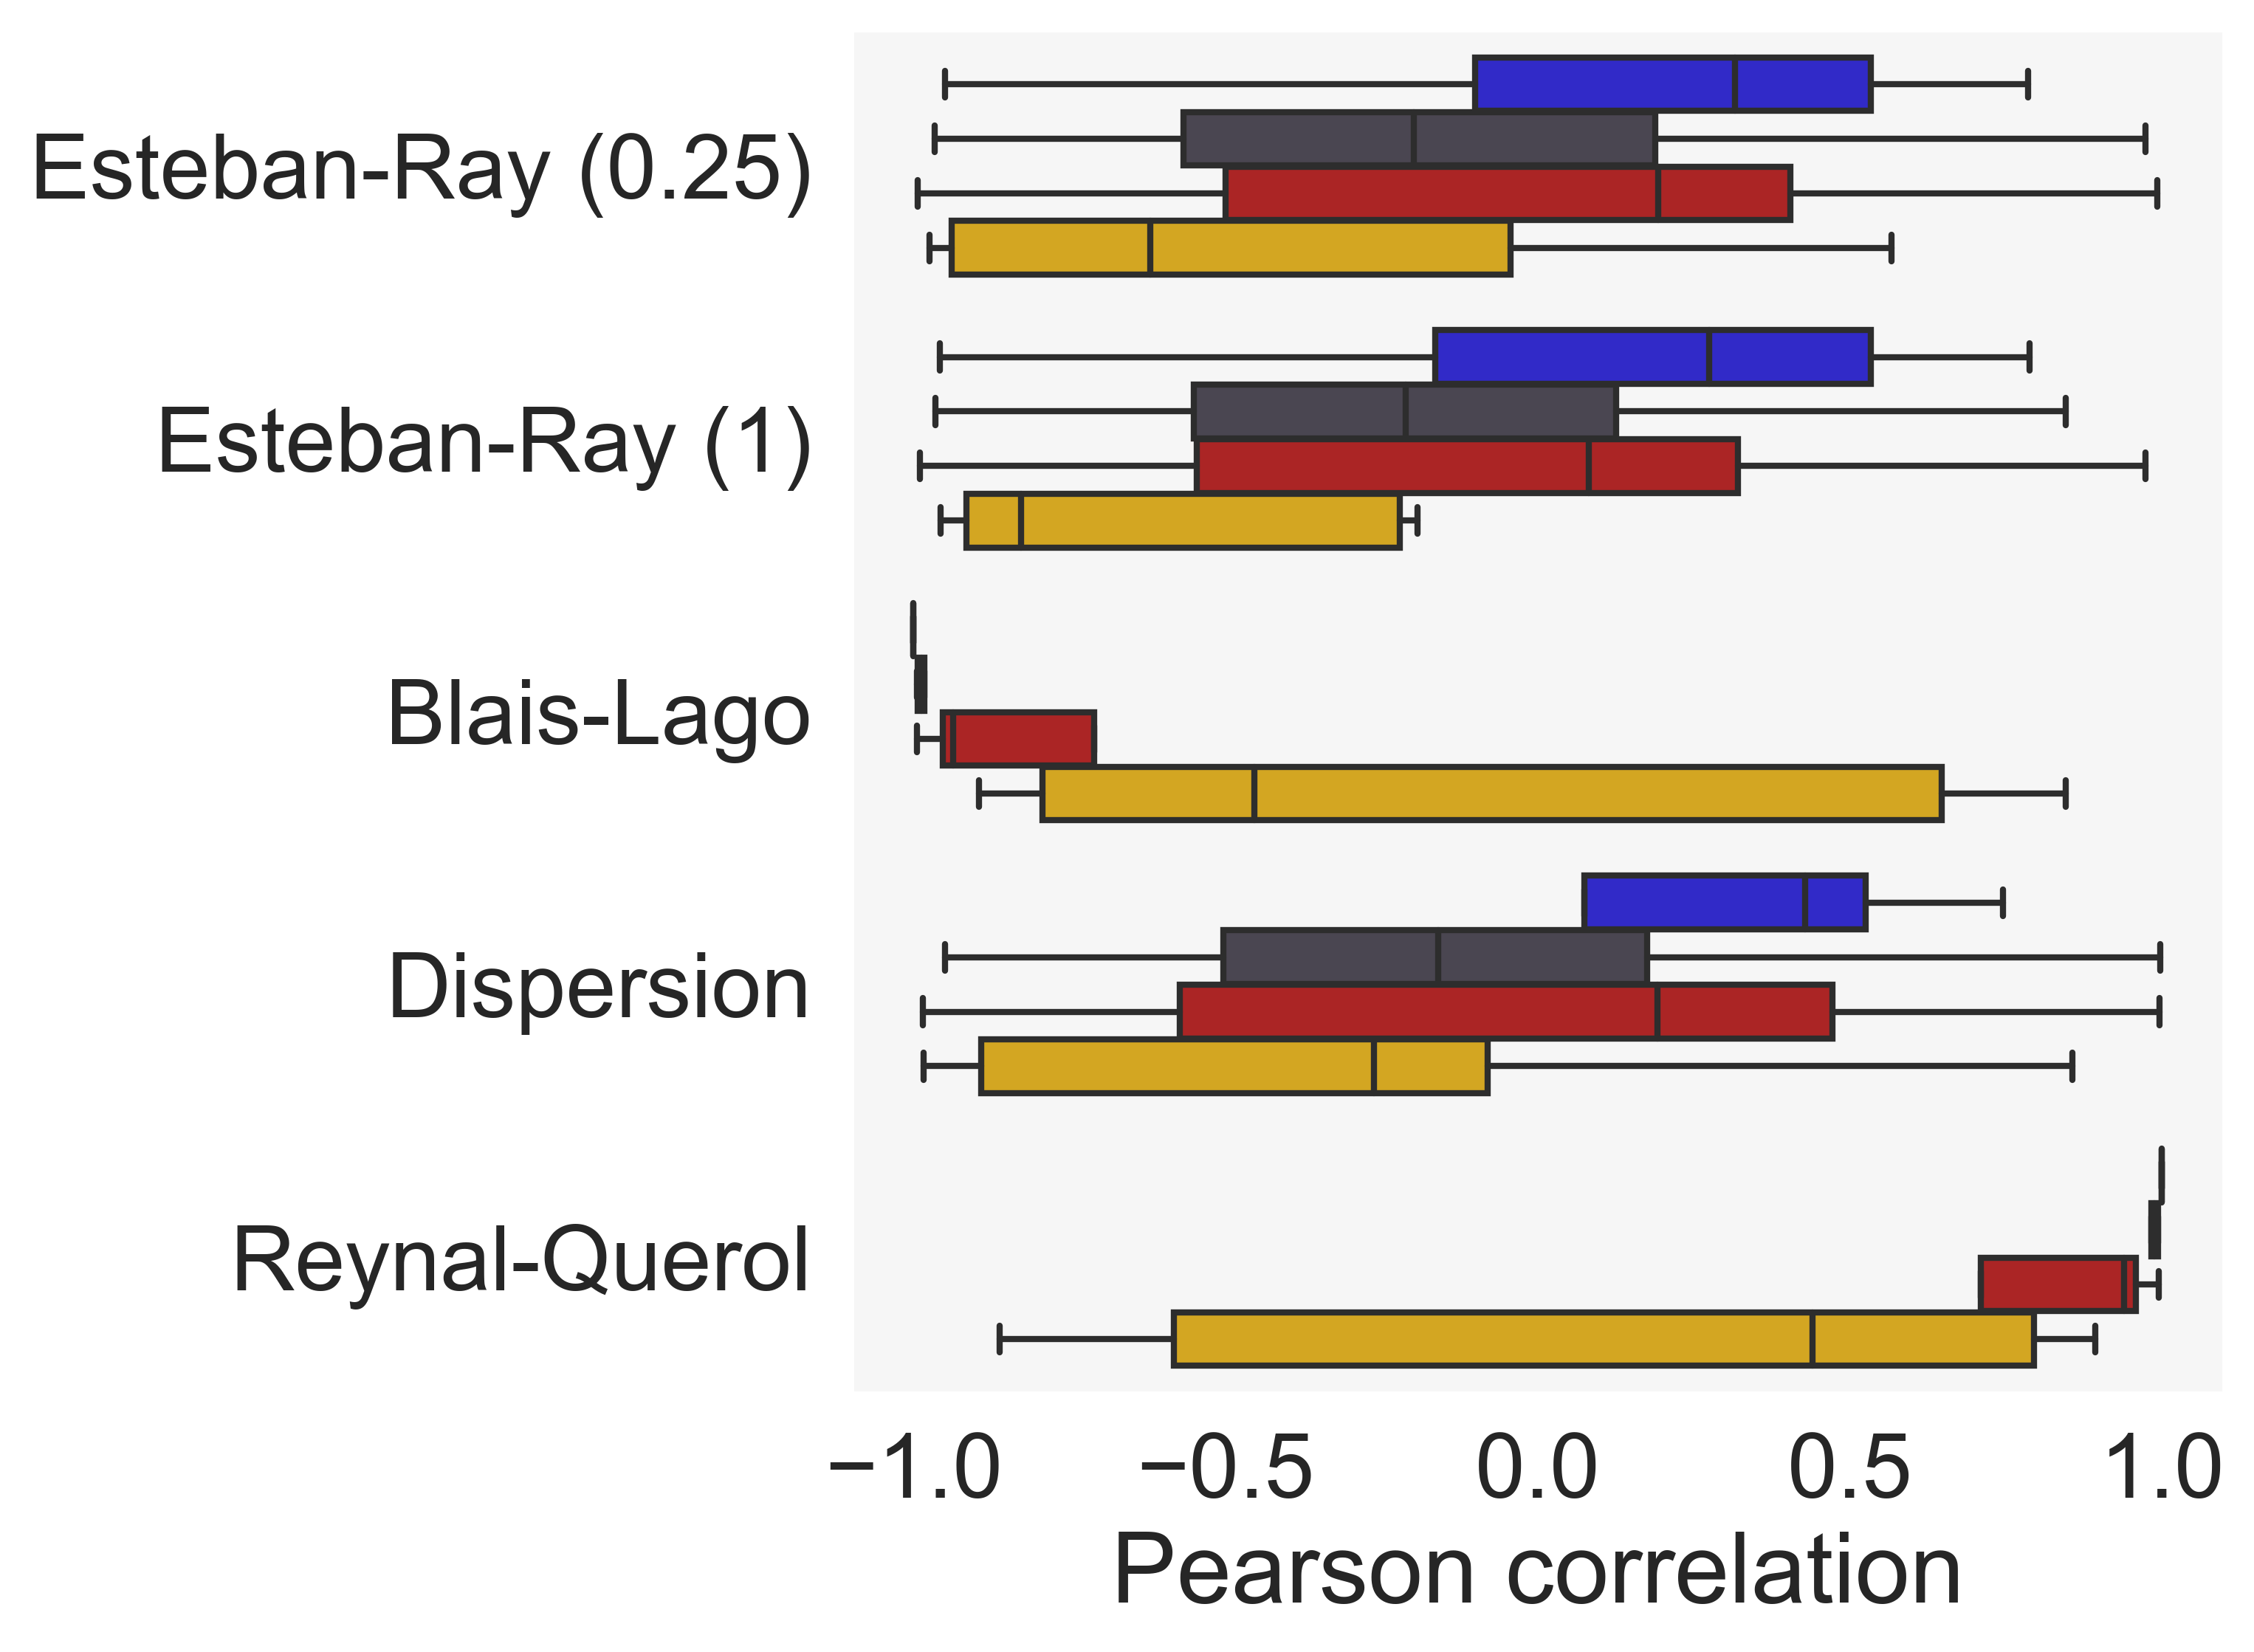

In [ ]:
sns.set(font_scale=2, rc={"axes.facecolor": "#f6f6f6", "axes.grid" : False})

fig, ax = plt.subplots(figsize=(6, 6), dpi=400)

ax = sns.boxplot(
    y="yy",
    x="value",
    hue="sigma",
    showfliers=False,
    palette=["#1910E2", "#4A4453", "#C10F0F", "#F0B505", "#007A1A"],
    data=data[(data["xx"] == "Between-EP") & ~(data["yy"].isin(["EP", "Between-EP", "Within-EP"]))]
)

# plt.xticks(rotation=90)
leg = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
leg.remove()
ax.set_xlabel("Pearson correlation")
ax.set_ylabel("")

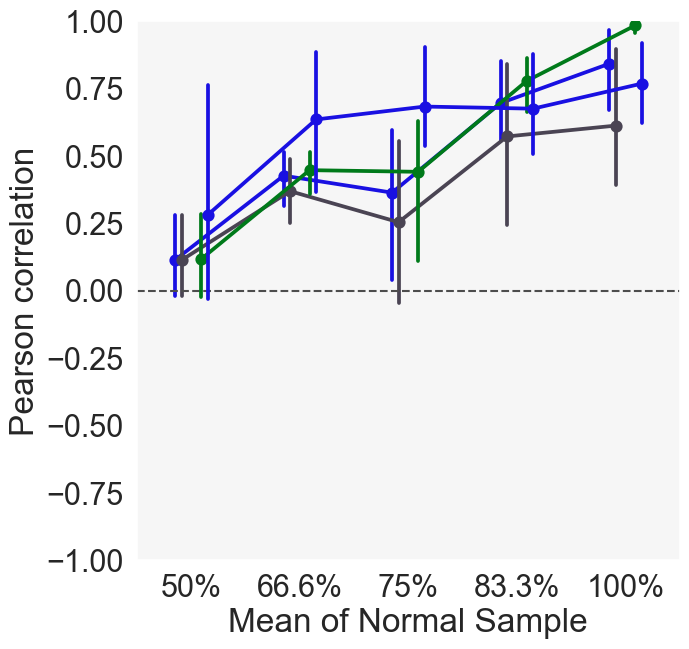

In [ ]:
sns.set(font_scale=2, rc={"axes.facecolor": "#f6f6f6", "axes.grid" : False})

order = ["Esteban-Ray (0.25)", "Esteban-Ray (1)", "Tsui-Wang (0.5)", "Tsui-Wang (0.75)", "Dispersion", "Reynal-Querol"]

fig, ax = plt.subplots(figsize=(7, 7))
sns.pointplot(x="mu", y="value", hue="yy", dodge=0.3, hue_order=order,
    palette=["#1910E2", "#4A4453", "#C10F0F", "#F0B505", "#007A1A"],
    data=data[(data["xx"] == "EP") & ~(data["yy"].isin(["EP", "Between-EP", "Within-EP"]))])
ax.axhline(y=0, ls="--", c=".3")
ax.set_ylabel("Pearson correlation")
ax.set_xlabel("Mean of Normal Sample")
ax.set_xticklabels(["50%", "66.6%", "75%", "83.3%", "100%"])
ax.set_ylim(-1, 1)
lgd = plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
lgd.remove()